### Prelims

In [ ]:
import numpy as np
from numpy import random
import pandas as pd
import sympy as sp
from sympy import symbols,diff, simplify, integrate
from sympy.stats import cdf, Normal

import math
from math import pow, exp, sqrt
from scipy import stats
norm = stats.norm

import timeit
from tqdm import tqdm
import matplotlib.pyplot as plt

import numba
from numba.np.ufunc import parallel
from scipy.special import erf
! pip install latex

#!pip install torch
#import latex
#import torch

Mark

We are basically trying to find the price or expected value of the payoff

$\int_0^T \sigma(t)^2 dt$.

We know under the risk neutral measure

$log(S_T)  = log(S_0) + \int_0^T r(t) dt - 1/2 \int_0^T \sigma(t)^2 dt + \int_0^T \sigma(t) dB_t$.  

The price is the expected discounted value.  Assuming the risk free rate is constant, the value of the contract which pays off $log(S_T)$ is

$E[e^{-r T} log(S_T)]$

which is equal to

$log(S_0) + e^{-rT} rT -e^{-rT} \frac{1}{2} E[\int_0^T \sigma(t)^2 dt]$  

which can be rearranged to find the price  (using discounting) or expected value of the integral.  The key is a portfolio of options can be used to find

$E[e^{-rT} log(S_T)]$.  

We find a portfolio of options which has payoffs $log(S_T)$ and its price is the discounted expectation we are looking for(of course everything is in the risk neutral measure).  The portfolio is given by the integral which is in my class notes.  Try evaluating the integral to see what you get and then look at the other pieces of the VIX.


ME

$log(S_T)  = log(S_0) + \int_0^T r(t) dt - 1/2 \int_0^T \sigma(t)^2 dt + \int_0^T \sigma(t) dB_t$

$log(S_T)-log(S_0)=log(\frac{S_T}{S_0})=\int_0^T r(t) dt - 1/2 \int_0^T \sigma(t)^2 dt$

$log(\frac{S_T}{S_0}) \approx rT - \frac{1}{2}\sigma(t)^2 T$

$\sigma(t)^2 = \frac{2}{T}[rT - log(\frac{S_T}{S_0})] ≈ \frac{2}{T}[\int_0^T r(t) dt - \int_0^T log(S_t) dt]$

Mark

Actually I meant the payoff to the portfolio in the integral

$\int_0^F (K-S_T)^+ \frac{1}{K^2} dK + \int_F^\infty (S_T - K)^+ \frac{1}{K^2} dK$  

notice where the options are in the money you get integrals of $\frac{1}{K}$ and $\frac{1}{K^2}$.  The integral of 1/K gives log you need to evaluate at the end points remember for K=0 the option is out of the money $(K-S_T)^+ =0$ so you aren't integrating over K=0 which would be a problem. (Actually, the lower boundary will be something like S_T) and the definition of F is in the notes.

In [ ]:
from sympy import oo,mellin_transform
S,K,F= symbols('S K F', real=True)
print('puts')
puts=sp.Max(K-S,0)
puts/=(K**2)
display(integrate(puts,(K,S,F)))


print('----------')
print('calls')
calls=sp.Max(S-K,0)
calls/=(K**2)
display(integrate(calls,(K,F,S)))
#display(integrate(calls,K))
#RHS = integrate(calls, K)


puts


Piecewise((log(F) - log(S) - 1 + S/F, F > S), (0, True))

----------
calls


Piecewise((log(F) - log(S) - 1 + S/F, F < S), (0, True))

$\int (K-S_T)^+ \frac{1}{K^2} dK = \begin{array}{lr} 0 & if K \leq S_T \\ log(\frac{K}{S_T})-1+\frac{S_T}{K} & otherwise \end{array}$

\

$\int (S_T-K)^+ \frac{1}{K^2} dK = \begin{array}{lr} -log(K)-\frac{S_T}{K} & if K \leq S_T \\ -log(S_T)-1 & otherwise \end{array}$

------------------
So,

$\int_0^F (K-S_T)^+ \frac{1}{K^2} dK$ =$log(K/S)-1+\frac{S}{K}|_{S_T}^F$=$log(F/S)-1+\frac{S}{F}$

and

$\int_F^\infty (S_T - K)^+ \frac{1}{K^2} dK$=$-log(S)-1|_F^\infty$=0

Therefore

$\int_0^F (K-S_T)^+ \frac{1}{K^2} dK + \int_F^\infty (S_T - K)^+ \frac{1}{K^2} dK = \frac{S_T}{K}+log(\frac{K}{S_T})-1$

#### The VIX originates from trying to price the log contract, which pays off log($\frac{S(T)}{S(0)}$) at time T. The log contract gives us insight about expected future volatility.

#### The value of the log contract is: $E^*[e^{-rT} log(\frac{S(T)}{S(0)})] = e^{-rT}E^*[rT - \frac{1}{2} \int_{0}^{T} \sigma(t)^2 \,dt]$

#### The objective of the VIX is to replicate the payoff of the log contract using a portfolio of out-of-the money options on the S&P 500 Index.

#### Let $ \hat{\sigma}^2 = \frac{1}{T} E^*  [\int_{0}^{T} \sigma(t)^2 \,dt ]$ and $F_{0,T} = e^{rT}S(0)$

#### Then $ \hat{\sigma}^2 = \frac{2e^{rT}}{T} (\int_{0}^{F_{0,T}} \frac{1}{K^2} P(K) \,dK + \int_{F_{0,T}}^{\infty} \frac{1}{K^2} C(K) \,dK)$

#### where P(K) is a put with strike price K and C(K) is a call strike price K

#### We can think about the VIX as a portfolio of options that approximates the following: $\hat{\sigma} = \frac{2e^{rT}}{T} (\,\sum_{K_i \leq K_0}{\frac{\Delta K_i}{K_i^2}P(K_i)} +  \sum_{K_i > K_0}{\frac{\Delta K_i}{K_i^2}C(K_i)} \,)-\frac{1}{T}(\frac{e^{rT}S(0)}{K_0} - 1)^2$

#### where $K_0$ is the first strike price below $e^{rT}S(0), \Delta K_i = \frac{K_{i} - K_{i-1}}{2}$. The last term is a correction term for the fact that there may not be an option with strike price equal to $e^{rT}S(0)$. It is the interval between strike prices - half the difference between the strike on either side of $K_i$.

#### (**Note**: $\Delta$K for the lowest strike is simply the difference between the lowest strike and the next higher strike. Likewise, $\Delta$K for the highest strike is the difference between the highest strike and the next lower strike.)

#### Q($K_i$) is the midpoint of the bid-ask spread for each option with strike $K_i$

The contract loses time value at a constant rate proportional to its vari- ance, so that at expiration, all the initial variance has been lost.
The log contract’s exposure to stock price is

$Δ=-\frac{2}{T}\frac{1}{S}$

shares of stock. That is, since each share of stock is worth S, you need a constant long position in $(2/T) worth of stock to be hedged at any time.

In [ ]:
St, K, v, T, t = symbols('S_t S_* \sigma^2, T, t', real=True)
fwd_contracts = (St-K)/K
log_contract = sp.log(St/K)
var_remain = (T-t)*v
final = fwd_contracts-log_contract+var_remain
display(final)

print('stock price exposure')
print('--------------------')
dV_dS = diff(final,St)
display(dV_dS)
display(diff(log_contract,St))

final2 = (2/T)*(fwd_contracts-log_contract+var_remain/2)
display( diff(final2,St) )

print('--------------------')

print('variance exposure')
print('--------------------')
pi_t = fwd_contracts-log_contract+var_remain/2
display(diff(pi_t,v))
print( f'initial var exposure: {float( diff(pi_t,v).subs({T:1, t:0})  )}' )
pi_t_2 = pi_t * (2/T)
display(diff(pi_t_2,v))
print( f'new var exposure: {float( diff(pi_t_2,v).subs({T:1, t:0})  )}' )
print('--------------------')

# show that if S* = st then final has no exposure to the stock price

\sigma^2*(T - t) - log(S_t/S_*) + (-S_* + S_t)/S_*

stock price exposure
--------------------


-1/S_t + 1/S_*

1/S_t

2*(-1/S_t + 1/S_*)/T

--------------------
variance exposure
--------------------


T/2 - t/2

initial var exposure: 0.5


2*(T/2 - t/2)/T

new var exposure: 1.0
--------------------


In [ ]:
S0, K, r, sig, T = symbols('S0 K r sig T', real=True)
d1 = (sp.log(S0/K) + (r + sig**2/2) * T)/(sig*sp.sqrt(T))
d2 = d1 - sig*sp.sqrt(T)
x = Normal('x', 0, 1)
c = S0 * simplify(cdf(x))(d1) - K * sp.exp(-r*T) * simplify(cdf(x))(d2)
dk_dc=diff(c,K)
d2K_dc2=diff(dk_dc,K)
#display(dk_dc)
display(d2K_dc2)
#bs_delta = diff(c, S0)
#print('delta')
#print( float( bs_delta.subs({S0:100, sig:0.3, K:100, T:1, r:0.03})  ) )

sqrt(2)*(-sqrt(T)*sig + (T*(r + sig**2/2) + log(S0/K))/(sqrt(T)*sig))*exp(-T*r)*exp(-(-sqrt(T)*sig + (T*(r + sig**2/2) + log(S0/K))/(sqrt(T)*sig))**2/2)/(2*sqrt(pi)*K*T*sig**2) + sqrt(2)*exp(-T*r)*exp(-(-sqrt(T)*sig + (T*(r + sig**2/2) + log(S0/K))/(sqrt(T)*sig))**2/2)/(2*sqrt(pi)*K*sqrt(T)*sig) + sqrt(2)*S0*exp(-(T*(r + sig**2/2) + log(S0/K))**2/(2*T*sig**2))/(2*sqrt(pi)*K**2*sqrt(T)*sig) - sqrt(2)*S0*(T*(r + sig**2/2) + log(S0/K))*exp(-(T*(r + sig**2/2) + log(S0/K))**2/(2*T*sig**2))/(2*sqrt(pi)*K**2*T**(3/2)*sig**3)

#### Distributions to Option Prices

$f(S_T)=max(S_T-K,0)$=$\frac{S_T-K + |S_T-K|}{2}$

$\frac{∂f}{∂K}$

sign(K - S_T)/2 - 1/2

DiracDelta(K - S_T)

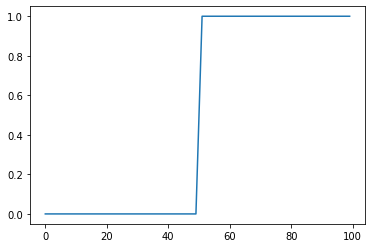

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


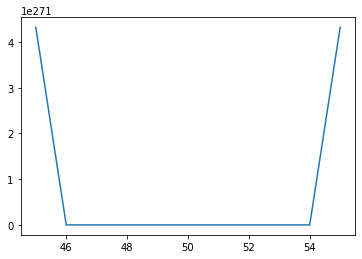

In [ ]:
S, K, T, t = symbols('S_T K, T, t', real=True)
#f = sp.maximum(S-K,0)
f= (S-K+sp.Abs(S-K))/2

#display(final)
df_dk = diff(f,K)
display(df_dk)

df2_d2k = diff(df_dk,K)
display(df2_d2k)

def first_deriv(S,K):
  return np.sign(K-S)/2 - 1/2

ST=np.arange(0,100)
K=50
plt.plot(ST,first_deriv(ST,K)*-1)
plt.show()
payoff_dict={}
#for s in ST:
#  payoff_dict[s]=float(df2_d2k.subs({S:s,K:50,T:1,t:1}))
#plt.plot(*zip(*payoff_dict.items()))
#plt.show()

#df2_d2k.subs({S:100,K:50})

def sec_deriv(S,K,a):
  lhs=1/(np.pi*abs(a))
  rhs=np.exp((-(S-K)/a)**2)
  return lhs*rhs

a=0.2
plt.plot(ST,sec_deriv(ST,K,a))
plt.show()

$(\mu-\frac{\sigma^2}{2})\,dt+\sigma\sqrt{dt}\phi(0,1)$

$E[ (\mu-\frac{\sigma^2}{2})\,dt+\sigma\sqrt{dt}\phi(0,1) ]$


$= (\mu-\frac{\sigma^2}{2})\,dt $


$\int_{t=1}^T\mu dt=\lim \sum_{t=1}^T\mu \Delta t$

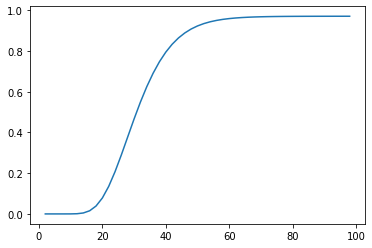

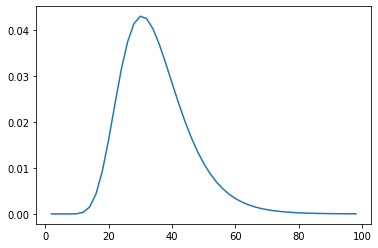

In [ ]:
S0, K, r, sig, T = symbols('S0 K r sig T', real=True)
d1 = (sp.log(S0/K) + (r + sig**2/2) * T)/(sig*sp.sqrt(T))
d2 = d1 - sig*sp.sqrt(T)
x = Normal('x', 0, 1)
c = S0 * simplify(cdf(x))(d1) - K * sp.exp(-r * T) * simplify(cdf(x))(d2)
dk_dc=diff(c,K)
d2K_dc2=diff(dk_dc,K)
#display(dk_dc)
#display(d2K_dc2)
#bs_delta = diff(c, S0)
#print('delta')
#print( float( bs_delta.subs({S0:100, sig:0.3, K:100, T:1, r:0.03})  ) )

payoff_dict={}
for s in range(0,100,2):
  payoff_dict[s]=-1*float(dk_dc.subs({S0:s, sig:0.3, K:30, T:1, r:0.03}))
plt.plot(*zip(*payoff_dict.items()))
plt.show()

payoff_dict={}
for s in range(0,100,2):
  payoff_dict[s]=float( d2K_dc2.subs({S0:s, sig:0.3, K:30, T:1, r:0.03})  )
plt.plot(*zip(*payoff_dict.items()))
plt.show()

#S,S_ref,T= symbols('S S* T', real=True)
#payoff=-sp.log(S/S_ref)*(2/T)
#delta = diff(payoff, S)
#delta

In [ ]:
class BSOPM_Class:

  def disc_function(self, FV, r, T):
    PV = FV * np.exp(-r*T)
    return PV

  def bs_d1_d2(self,St,r,t,K,call,sig):
    d1 = np.log(St/K)
    d1 += ( sig*sig/2 + r)*t
    with np.errstate(divide='ignore'):
        d1/=sig * t**0.5
    d2=d1-sig * t**0.5
    return d1,d2

  def cdf_approx(self,dn,call):
    if call:
      Ndn = (0.50 * (1.0 + erf(dn / math.sqrt(2.0))))
    else:
      Ndn = (0.50 * (1.0 + erf(-dn / math.sqrt(2.0))))
    return Ndn

  def bs_delta(self,d1,d2,call):
    Nd1 = self.cdf_approx(dn=d1,call=call)
    Nd2 = self.cdf_approx(dn=d2,call=call)
    return Nd1,Nd2

  def bs_gamma(self,d1,St,sig,t):
    gamma = norm.pdf(d1)
    with np.errstate(divide='ignore'):
        gamma /= (St*sig*np.sqrt(t))
    return gamma

  def bs_price(self,St,r,t,K,call,Nd1,Nd2,T):
    pvk = self.disc_function(K,r, T-t)
    if call:
      price = St*Nd1-pvk*Nd2
    else:
      price = pvk * Nd2 - St * Nd1
    return price

  def opt_payoff(self, ST, K, call=True):
    if call == True:
      payoff=np.maximum(ST-K,0)
    else:
      payoff=np.maximum(K-ST,0)
    return payoff

  def __init__(self,S0,r,sigma,t,T,K,call=True):
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T  = T
    self.K = K
    self.call = call
    self.t = t

    self.d1,self.d2=self.bs_d1_d2(St=self.S0,r=self.r,t=self.T-self.t,K=self.K,call=self.call,sig=self.sigma)
    self.Nd1,self.Nd2=self.bs_delta(d1=self.d1,d2=self.d2,call=self.call)
    self.delta=self.Nd1
    self.gammas = self.bs_gamma(d1=self.d1,St=self.S0,sig=self.sigma,t=self.T-self.t)
    self.price = self.bs_price(St=self.S0,r=self.r,t=self.t,K=self.K,call=self.call,Nd1=self.Nd1,Nd2=self.Nd2,T=self.T)
    self.payoff = self.opt_payoff(self.S0,self.K,self.call)


In [ ]:
class ButterflySpread:
  def spread_payoff(self,K_low,K_mid,K_high,St,call):
    strikes = [K_low,K_mid,K_high]
    weights = [1,-2,1]
    func = lambda k : BSOPM_Class(S0=St,r=self.r,sigma=self.sigma,t=self.t,T=self.T,K=k,call=call).payoff
    vfunc = np.vectorize(func)
    port_payoff = vfunc(strikes)@weights
    return port_payoff

  def spread_payoff_range(self,K_low,K_mid,K_high,prices,call):
    func = lambda S : self.spread_payoff(K_low,K_mid,K_high,S,call)
    vfunc = np.vectorize(func)
    payoff_range = vfunc(prices)
    payoff_dict = {k:v for k,v in zip(prices,payoff_range)}
    return payoff_dict

  def __init__(self,r,sigma,t,T,K_mid,K_diff,price_range,call=True):
  #def __init__(self, St, r, sigma, T, K_mid,K_diff,price_range):
    #self.St=St
    self.r=r
    self.sigma=sigma
    self.T=T
    self.t=t
    self.K_diff=K_diff
    self.K_mid=K_mid
    self.K_high=self.K_mid+K_diff
    self.K_low=self.K_mid-K_diff
    self.price_range=price_range
    self.call=call
    #self.payoff = self.spread_payoff(self.K_low,self.K_mid,self.K_high,self.St)
    self.payoff_range = self.spread_payoff_range(self.K_low,self.K_mid,self.K_high,self.price_range,self.call)


St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 5
t=0

call=True
bf_spread = ButterflySpread(r,sigma,t,T,K_mid,K_diff,prices,call=call)
#bf_spread = ButterflySpread(St,r,sigma,T,K_mid,K_diff,prices)

In [ ]:
class ButterflySpread_NEW:
  def spread_payoff(self,K_low,K_mid,K_high,St,call):
    strikes = [K_low,K_mid,K_high]
    weights = [1,-2,1]
    func = lambda k : BSOPM_Class(S0=St,r=self.r,sigma=self.sigma,t=self.t,T=self.T,K=k,call=call).payoff
    vfunc = np.vectorize(func)
    port_payoff = vfunc(strikes)@weights
    return port_payoff

  def spread_payoff_range(self,K_low,K_mid,K_high,prices,call):
    func = lambda S : self.spread_payoff(K_low,K_mid,K_high,S,call)
    vfunc = np.vectorize(func)
    payoff_range = vfunc(prices)
    payoff_dict = {k:v for k,v in zip(prices,payoff_range)}
    return payoff_dict

  def __init__(self,r,sigma,t,T,K_low,K_high,price_range,call=True):
    self.r=r
    self.sigma=sigma
    self.T=T
    self.t=t
    self.K_high=K_high
    self.K_low=K_low
    self.K_diff=self.K_high-self.K_low
    self.K_mid=(self.K_high+self.K_low)/2
    self.price_range=price_range
    self.call=call
    self.payoff_range = self.spread_payoff_range(self.K_low,self.K_mid,self.K_high,self.price_range,self.call)



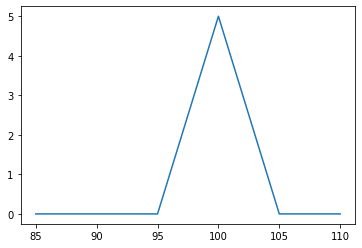

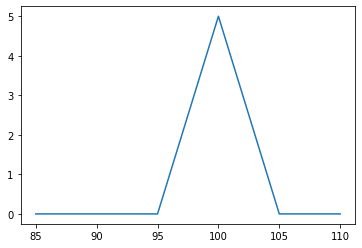

In [ ]:
St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 5
t=0
call=False
K_low=K_mid-K_diff
K_high=K_mid+K_diff

bf_spread=ButterflySpread(r,sigma,t,T,K_mid,K_diff,prices,call=call)
bf_spread_NEW=ButterflySpread_NEW(r,sigma,t,T,K_low,K_high,prices,call=call)

plt.plot(*zip(*bf_spread.payoff_range.items()))
plt.show()

plt.plot(*zip(*bf_spread_NEW.payoff_range.items()))
plt.show()

https://math.stackexchange.com/questions/2482197/solving-the-equation-with-sum-of-max-functions-relu

$max(S_T-K_1,0) - 2max(S_T-K_2,0) + max(S_T-K_3,0)$

$\frac{S_T-K_1+|S_T-K_1|}{2} -2 \frac{S_T-K_2+|S_T-K_2|}{2} + \frac{S_T-K_3+|S_T-K_3|}{2}$

$\frac{S_T-K_1+|S_T-K_1| -2(S_T-K_2+|S_T-K_2|) + S_T-K_3+|S_T-K_3|}{2}$

$\frac{-K_1+|S_T-K_1| -2(-K_2 + |S_T-K_2|) -K_3+|S_T-K_3|}{2}$

$\frac{-(K_2-\delta)+|S_T-(K_2-\delta)| -2(-K_2 + |S_T-K_2|) -(K_2+\delta)+|S_T-(K_2+\delta)|}{2}$

$\frac{-K_2+|S_T-(K_2-\delta)| -2(-K_2 + |S_T-K_2|) -K_2+|S_T-(K_2+\delta)|}{2}$

$\frac{|S_T-(K_2-\delta)| -2(|S_T-K_2|) +|S_T-(K_2+\delta)|}{2}$

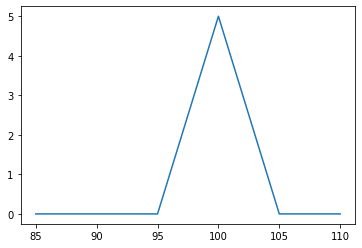

In [ ]:
#max(S1,0) -2max(S2,0) + max(S3,0)

def derived_butterfly(ST,K_low,K_mid,K_high):
  def helper(x):
    return (x+abs(x))/2
  def helper2(x):
    return x+abs(x)

  #return helper(ST-K_low)-2*helper(ST-K_mid)+helper(ST-K_high)
  #return ( helper2(ST-K_low)-2*helper2(ST-K_mid)+helper2(ST-K_high) ) / 2
  #return ( -K_low+abs(ST-K_low) +2*K_mid -2*abs(ST-K_mid) -K_high + abs(ST-K_high) ) / 2
  delt=5
  #return ( -(K_mid-delt)+abs(ST-(K_mid-delt)) +2*K_mid -2*abs(ST-K_mid) -(K_mid+delt) + abs(ST-(K_mid+delt)) ) / 2
  return ( abs(ST-(K_mid-delt)) -2*abs(ST-K_mid) + abs(ST-(K_mid+delt)) ) / 2



temp=derived_butterfly(prices,K_mid-K_diff,K_mid,K_mid+K_diff)
plt.plot(prices,temp)
plt.show()

### Proving out the integral using butterlfies

In [ ]:
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=0.1
call=True
S_diff=0.1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )
payoffs*=2*T

strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
def area_approx_check(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx
  area=K_diff*(K_diff/2)/2*scale_factor
  return area
temp=area_approx_check(strike_range,S_ref,K_diff)

def area_approx_check2(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  #spread_approx=K_diff/2
  delta=K_diff/2
  scale_factor=true_payoff/delta
  area=K_diff**2/4*scale_factor
  return area
temp2=area_approx_check2(strike_range,S_ref,K_diff)

def area_approx_check3(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  #spread_approx=K_diff/2
  delta=K_diff/2
  scale_factor=true_payoff/delta
  area=delta*(2*delta)*(1/2) * scale_factor
  return area
temp3=area_approx_check3(strike_range,S_ref,K_diff)

def area_approx_check4(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  #spread_approx=K_diff/2
  delta=K_diff/2
  scale_factor=true_payoff/delta
  area=delta**2 * (true_payoff/delta)
  return area
temp4=area_approx_check4(strike_range,S_ref,K_diff)

def area_approx_check5(K_mid,S_ref,K_diff):
  true_payoff=((K_mid/S_ref)-1)-np.log(K_mid/S_ref)
  true_payoff*=2/T
  area=true_payoff*K_diff
  return area
temp5=area_approx_check5(strike_range,S_ref,K_diff)
#  y=[i*scale_factor for i in y]

#plt.scatter(ST,payoffs)
#plt.show()

print( sum([p*S_diff for p in payoffs])  )
print('--------')
print( sum([a for a in temp]) * 2  )
print( sum([a for a in temp2]) * 2  )
print( sum([a for a in temp3]) * 2  )
print( sum([a for a in temp3]) * 2  )
print( sum([a for a in temp4]) * 2  )
print( sum([a for a in temp5])  )

1.1909744083002107
--------
1.1909744083002116
1.1909744083002116
1.1909744083002116
1.1909744083002116
1.1909744083002116
1.1909744083002107


### Approximating the VIX payoff the butterfly spreads (overlapping)

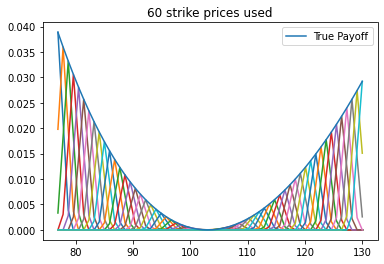

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=2
call=True

# Desired Payoff f(ST) = ((ST/S0)-1)-log(ST/S0)
N_contracts=1
#ST = np.around(np.arange(S0/1.3,(S0*1.3)+1),2)
num_strikes=60
ST = np.around(np.linspace(S0/1.3,(S0*1.3),num_strikes),2)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*N_contracts

#for s in ST[:]:
for s,p in zip(ST[:],payoffs[:]):
  bf_payoff=ButterflySpread(r=r,sigma=sigma,t=t,T=T,K_mid=s,K_diff=K_diff,price_range=ST,call=call)
  y=list(bf_payoff.payoff_range.values())
  #y=[i*p for i in y]
  y=[i*p/2 for i in y]
  plt.plot(ST,y)

plt.plot(ST,payoffs,label='True Payoff')
plt.legend()
plt.title(f'{num_strikes} strike prices used')
plt.show()

### Approximating the VIX Curve (non-overlapping)

buterflies give probability, sum the probabilties to get the curve
this integral gives the price of the VIX

In [ ]:
! pip show matplotlib
! pip install -U matplotlib

AttributeError: ignored

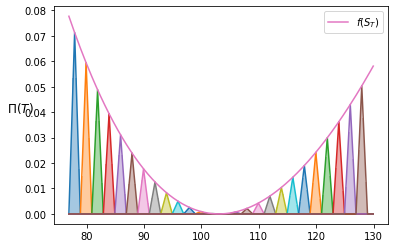

In [ ]:
#from matplotlib.scale import scale_factory
#plt.figure(figsize=(15,10))
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=2
call=True
S_diff=0.25

# Desired Payoff: f(ST) = ((ST/S0)-1)-log(ST/S0)
N_contracts=1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*N_contracts
payoffs*=2*T

#for s,p in zip( range(len(strike_range[:])-1) , payoffs[:] ):
area_approx=0
factors=[]
for s in range(len(strike_range[:])-1):
  bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
                                K_low=strike_range[s],K_high=strike_range[s+1],price_range=ST,call=call)
  y=list(bf_payoff.payoff_range.values())
  mid_price=bf_payoff.K_mid
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  true_payoff*=2*T
  #spread_approx=max(y)
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx

  factors.append(scale_factor)
  area_approx+=K_diff*(K_diff/2)*scale_factor/2

  y=[i*scale_factor for i in y]
  plt.fill_between(ST, y, step="mid", alpha=0.4)
  plt.plot(ST,y)

plt.plot(ST,payoffs,label=r'$f(S_T)$')
plt.legend()
plt.ylabel(r'$\Pi(T)$',size=12,rotation='horizontal',loc='top') #,
plt.xlabel('$S_T$',size=12)
plt.title(f'${K_diff} Strike Price Difference')
plt.show()

#print(factors)
# f(S)/g(S)

In [ ]:
#print(payoffs.sum())#true payoff
T=1
def payoff_int(S,S_ref):
  payoff_integral = S**2/(2*S_ref) - S*np.log(S/S_ref)
  payoff_integral*=(2/T)
  return payoff_integral

print(payoff_int(S0*1.3,S_ref)-payoff_int(S0/1.3,S_ref))
print( sum([p*S_diff for p in payoffs])  )
print(area_approx*2)
print(area_approx)

1.1886561617605764
1.2012089835845086
1.1262928991202568
0.5631464495601284


In [ ]:
#from matplotlib.scale import scale_factory
S0=100
r=0.03
sigma=0.3
T=1
t=0
S_ref=S0*np.exp(r*T)
K_diff=1
call=True
S_diff=0.25

# Desired Payoff: f(ST) = ((ST/S0)-1)-log(ST/S0)
N_contracts=1
ST = np.arange(S0/1.3,S0*1.3,S_diff)
strike_range = np.arange(S0/1.3,S0*1.3,K_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*N_contracts

area_approx=0
factors=[]
for s in range(len(strike_range[:])-1):
  bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
                                K_low=strike_range[s],K_high=strike_range[s+1],price_range=ST,call=call)
  #y=list(bf_payoff.payoff_range.values())
  mid_price=bf_payoff.K_mid
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx
  #factors.append(scale_factor)
  area_approx+=K_diff*(K_diff/2)*scale_factor/2
  #y=[i*scale_factor for i in y]


def payoff_int(S,S_ref):
  return S**2/(2*S_ref) - S*np.log(S/S_ref)

print(payoff_int(S0*1.3,S_ref)-payoff_int(S0/1.3,S_ref))
print( sum([p*S_diff for p in payoffs])  )
print(area_approx*2) # you only have half the area because of they are triangles
print(area_approx)

0.5943280808802882
0.6006044917922543
0.5918657673977897
0.29593288369889487


$ f(S_T)= \frac{S_T}{S_*}-1 - log(\frac{S_T}{S_0}) $

$ F(S_T) = \int_{S_T=S_L}^{S_T=S_H}f({S_T}) = \frac{S_T^2}{2S_*} + S_T - ( (S_Tlog(S_T) - S_T) - (S_Tlog(S_*) ) $



In [ ]:
S0=100
r=0.03
T=1
t=0
S_ref=S0*np.exp(r*(T-t))
S_diff=0.25
ST = np.arange(S0/1.3,S0*1.3,S_diff)
payoffs=( ((ST/S_ref)-1)-np.log(ST/S_ref) )*(2/T)

S,S_ref,T= symbols('S S* T', real=True)
payoff=((S/S_ref)-1) -sp.log(S/S_ref)
payoff*=2/T
display(integrate(payoff, S))
F_T = integrate(payoff, S)

print( float(F_T.subs({S:S_0*1.3, S_ref:S0*sp.exp(r*(T-t)), T:1})) - float(F_T.subs({S:S_0/1.3, S_ref:S0*sp.exp(r*(T-t)), T:1})) )

S=100
r=0.03
T=1
t=0
S_ref=S0*np.exp(r*(T-t))
def payoff_int(S,S_ref,T):
  return (2/T) * (S**2/(2*S_ref) - S*np.log(S/S_ref))

print(payoff_int(S*1.3,S_ref,T)-payoff_int(S/1.3,S_ref,T))
print( sum([p*S_diff for p in payoffs])  )

#float( bs_delta.subs({S0:100, sig:0.3, K:100, T:1, r:0.03})  )

print(pd.DataFrame(X).shape)
print(f'{len(strikes)} different strikes')
print(f'{len(ST)} different prices')

S**2/(S**T) - 2*S*log(S/S*)/T

1.1886561617605338
1.1886561617605764
1.2012089835845086


NameError: ignored

In [ ]:
print(f'{len(strikes)} different strikes')
print(f'{len(ST)} different prices')
print(pd.DataFrame(X).shape)

payoff
print( sum([p*S_diff for p in payoffs]) )

#X1=X.copy()
#for s,k in zip(range(len(strikes)),strikes):
#   X1[s][:] /= k**2
#sum(X1)

18 different strikes
54 different prices
(17, 54)
1.2529784535750361


In [ ]:
1.2529784535750361

In [ ]:
pd.DataFrame(X).shape

(53, 107)

### Log Contract Components

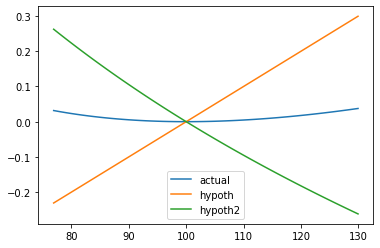

In [ ]:
#Log contract
S0=100
T=1
ST=np.arange(S0/1.3,S0*1.3)
payoffs=( ((ST/S0)-1)-np.log(ST/S0) )
payoffs2= ((ST/S0)-1)
payoffs3=-np.log(ST/S0)
#payoffs*=2/T
plt.plot(ST,payoffs,label='actual')
plt.plot(ST,payoffs2,label='hypoth')
plt.plot(ST,payoffs3,label='hypoth2')
plt.legend()
plt.show()

### Using Calls and Puts (proving the wieghts are 1/K^2)

In [ ]:
print(strikes[0],strikes[-1])
print('---------------')
for i in range(len(strikes)-1):
  print(strikes[i],strikes[i+1])


-6.096897407090037 0.169 -1.0161495678483394
0.939967831583473 0.15655091471124694 0.15666130526391214
0.8731418463045664 0.14542838555560528 0.14552364105076104
0.8131982914241038 0.13545042073786018 0.135533048570684
0.7592233532225379 0.12646520036876954 0.12653722553708965
0.7104500223774715 0.11834526706465223 0.1184083370629119
0.666230671765772 0.11098298085839098 0.11103844529429534
0.6260154302970554 0.10428693346431936 0.10433590504950924
0.589334993642213 0.09817909726353362 0.09822249894036882
0.5557868610839451 0.09259254186251269 0.09263114351399085
0.5250242396057474 0.08746959267118679 0.08750403993429123
0.4967470403576628 0.08276033634975988 0.0827911733929438
0.4706945283725894 0.07842140041131793 0.07844908806209823
0.4466392874418652 0.07441495097639902 0.07443988124031087
0.42438223790539076 0.07070786522495143 0.07073037298423179
0.40374850251427086 0.06727104459194538 0.0672914170857118
0.3845839592919176 0.06407884200053386 0.06409732654865292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


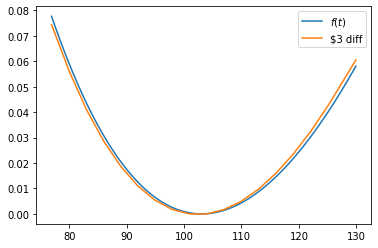

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
#t=0
t=1
T=1
S_ref=S0*np.exp(r*T)
S_diff=0.1
K_diff=3

ST = np.arange(S0/1.3,(S0*1.3),S_diff)
payoffs = ((ST/S_ref)-1)-np.log(ST/S_ref)
payoffs*=(2/T)
strikes = np.arange(S0/1.3,S0*1.3,K_diff )

def p_func(S,F,t):
  payoff =((S/F)-1)-np.log(S/F)
  payoff *=(2/T)
  return payoff

rep_payoff=np.zeros(len(ST))
cum_weight=0
for i in range(len(strikes)-1):
  k_0=strikes[i]
  k_1=strikes[i+1]
  f_0=p_func(k_0,S_ref,T)
  f_1=p_func(k_1,S_ref,T)
  slope=(f_1-f_0)/(k_1-k_0)

  #weight=1/(k_0**2)
  weight=slope-cum_weight
  #weight/=2

  cum_weight+=weight
  #print(weight,1/(k_0**2),weight/2)

  print(weight*1_000,1/(k_0**2)*1_000,(weight/2/K_diff)*1_000)
  #print(round(weight,5),round(1/(k_0**2),5),round(weight*2,5))

  if k_0<=S_ref:
    call=False
  else:
    call=True

  opt_payoff=BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=k_0,call=call).payoff
  opt_payoff*=weight
  rep_payoff+=opt_payoff

#print(len(strikes))

plt.plot(ST,payoffs,label='$f(t)$')
plt.plot(ST,rep_payoff,label=f'${K_diff} diff')
plt.legend()
plt.show()

#half of K_dist is 1/k**2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


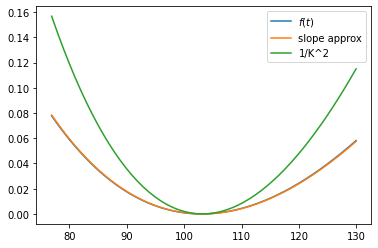

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
#t=0
t=1
T=1
S_ref=S0*np.exp(r*T)
S_diff=0.1
K_diff=0.5

ST = np.arange(S0/1.3,(S0*1.3),S_diff)
payoffs = ((ST/S_ref)-1)-np.log(ST/S_ref)
payoffs*=(2/T)
strikes = np.arange(S0/1.3,S0*1.3,K_diff )

def p_func(S,F,t):
  payoff =((S/F)-1)-np.log(S/F)
  payoff *=(2/T)
  return payoff

rep_payoff=np.zeros(len(ST))
eqw_payoff=np.zeros(len(ST))
cum_weight=0
for i in range(len(strikes)-1):
  k_0=strikes[i]
  k_1=strikes[i+1]
  f_0=p_func(k_0,S_ref,T)
  f_1=p_func(k_1,S_ref,T)
  slope=(f_1-f_0)/(k_1-k_0)

  #weight=1/(k_0**2)
  weight=slope-cum_weight
  #weight/=2
  weight_2=1/(k_0**2)

  cum_weight+=weight
  #print(weight,1/(k_0**2),weight/2)


  if k_0<=S_ref:
    call=False
  else:
    call=True

  opt_payoff=BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=k_0,call=call).payoff
  opt_payoff*=weight

  eqw_payoff+=weight_2*BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=k_0,call=call).payoff
  rep_payoff+=opt_payoff

#payoffs*=100
#rep_payoff*=100
#eqw_payoff*=100

#eqw_payoff*=-1
#eqw_payoff += (ST-S_ref)/S_ref
eqw_payoff*=2/T

plt.plot(ST,payoffs,label='$f(t)$')
plt.plot(ST,rep_payoff,label=f'slope approx')
plt.plot(ST,eqw_payoff,label=f'1/K^2')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def spread_payoff(S,K,delta):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_payoff(S,K):
    return np.maximum(S-K,0)
  payoffs=np.array([call_payoff(S,k) for k in strikes])
  #print(payoffs.shape)
  payoffs=payoffs.T@weights
  return payoffs

delta = 0.1
S=100
F=S*np.exp(0.03)
K=100

ST=np.arange(S/1.2,S*1.2,0.1)
#spread_payoff(S,K,delta)

#plt.plot(ST,spread_payoff(ST,K,delta))
#plt.show()



f=(S/F-1)-np.log(S/F)

strikes are rows, STs the columns

$
\begin{equation*}
\textbf{X}^{NxM}=
\begin{array}{rcl}
\\ \begin{array}{r}  (S_T)_1\ & (S_T)_2\ & \cdots\ (S_T)_M\  \end{array} \\
\begin{array}{c}  K_1\\   K_2\\  \vdots\\  K_N\\ \end{array}
\begin{pmatrix}
payoff() & \textbf{w}_{1,2} & \cdots & \textbf{w}_{1,I} \\
\textbf{w}_{2,1} & \textbf{w}_{2,2} & \cdots & \textbf{w}_{2,I} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\textbf{w}_{N,1} & \textbf{w}_{N,2} & \cdots & \textbf{w}_{N,I}
\end{pmatrix}
\end{array}
\end{equation*}
$

$
\begin{equation*}
\textbf{S}^{Mx1}
\
\begin{pmatrix} \end{pmatrix}
\end{equation*}
$

In [ ]:
for s in range(len(strike_range[:])-1):
  bf_payoff=ButterflySpread_NEW(r=r,sigma=sigma,t=t,T=T,
                                K_low=strike_range[s],K_high=strike_range[s+1],price_range=ST,call=call)
  #y=list(bf_payoff.payoff_range.values())
  mid_price=bf_payoff.K_mid
  true_payoff=((mid_price/S_ref)-1)-np.log(mid_price/S_ref)
  spread_approx=K_diff/2
  scale_factor=true_payoff/spread_approx
  area_approx+=K_diff*(K_diff/2)*scale_factor/2

(54,)
(54,)
54 different strikes
266 different prices
(54, 266)
---------


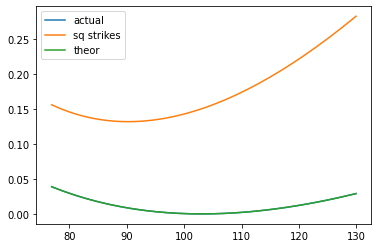

In [ ]:
# Initial params
S0=100
r=0.03
sigma=0.3
t=0
T=1
S_ref=S0*np.exp(r*T)
S_diff=0.2
K_diff=1

# Desired Payoff f(ST) = ((ST/S0)-1)-log(ST/S0)
N_contracts=1
ST = np.arange(S0/1.3,(S0*1.3),S_diff)
payoffs = ((ST/S_ref)-1)-np.log(ST/S_ref)
#payoffs*=2
strikes = np.arange( (S0/1.3),(S0*1.3),K_diff )

X=[]
for strike in strikes[:]:
  if strike<=S_ref:
    call=True
  else:
    call=False
  bso = BSOPM_Class(S0=ST,r=r,sigma=sigma,t=t,T=T,K=strike,call=call)
  X.append(bso.payoff)

print(np.array([1/k**2 for k in strikes]).shape)
print((np.linalg.pinv(X).T@payoffs).shape)
print(f'{len(strikes)} different strikes')
print(f'{len(ST)} different prices')
print(pd.DataFrame(X).shape)
print('---------')
weights=np.linalg.pinv(X).T@payoffs
theor_weights=np.array([1/k**2 for k in strikes])
theor_weights*=2

#print(pd.DataFrame(X).shape)
#print(pd.DataFrame(weights).shape)
#print(pd.DataFrame(theor_weights).shape)



plt.plot(ST,np.array(X).T@weights,label='actual')
plt.plot(ST,np.array(X).T@theor_weights,label='sq strikes')
plt.plot(ST,payoffs,label='theor')
plt.legend()
plt.show()

#print(np.array([1/k**2 for k in strikes]))
#print('-------')
#np.linalg.pinv(X).T@payoffs


In [ ]:
print(weights*100)
#print(theor_weights*100*2)
print(theor_weights*100)

[-0.19251175  0.03313903  0.0302699   0.02915723  0.02771301  0.02647568
  0.02529067  0.02419725  0.02314602  0.02225858  0.02105496  0.02133052
  0.01624625  0.0257209   0.01143991  0.02074028  0.01600239  0.01648058
  0.01562333  0.01516518  0.01460105  0.01423517  0.01332617  0.01456995
  0.0077515   0.03164541 -0.07047484]
[0.0338     0.03210865 0.03054114 0.02908568 0.02773183 0.02647036
 0.02529304 0.02419256 0.02316236 0.0221966  0.02129    0.02043783
 0.01963582 0.01888011 0.0181672  0.01749392 0.01685738 0.01625497
 0.01568428 0.01514312 0.0146295  0.01414157 0.01367765 0.01323619
 0.01281577 0.01241506 0.01203285]


In [ ]:
print(f'{len(strikes)} different strikes')
print(f'{len(ST)} different prices')
print(pd.DataFrame(X).shape)

print( sum([p*S_diff for p in payoffs]) )

X1=X.copy()
for s,k in zip(range(len(strikes)),strikes):
   X1[s][:] /= k**2
sum(X1)

18 different strikes
54 different prices
(18, 54)
0.6264892267875181


array([1.13381512e-14, 1.18301635e-14, 1.23221759e-14, 1.28141883e-14,
       1.39068520e-14, 1.49995157e-14, 1.60921794e-14, 1.76321409e-14,
       1.91721023e-14, 2.07120638e-14, 2.25886309e-14, 2.44651981e-14,
       2.63417652e-14, 2.84741227e-14, 3.06064802e-14, 3.27388377e-14,
       3.50673521e-14, 3.73958665e-14, 3.97243808e-14, 4.22046092e-14,
       4.46848375e-14, 4.71650659e-14, 4.97635764e-14, 5.23620870e-14,
       5.49605976e-14, 5.76520212e-14, 6.03434447e-14, 6.30348682e-14,
       6.57997945e-14, 6.85647209e-14, 7.13296472e-14, 7.41531103e-14,
       7.69765734e-14, 7.98000364e-14, 8.26704120e-14, 8.55407876e-14,
       8.84111633e-14, 9.13193603e-14, 9.42275574e-14, 9.71357545e-14,
       1.00074616e-13, 1.03013478e-13, 1.05952340e-13, 1.08916198e-13,
       1.11880056e-13, 1.14843914e-13, 1.17828251e-13, 1.20812588e-13,
       1.23796926e-13, 1.26798123e-13, 1.29799320e-13, 1.32800517e-13,
       1.35815659e-13, 1.38830801e-13])

In [ ]:
print(np.array(X).shape)
print(np.reshape(payoffs,(-1,1)).shape)
#np.linalg.pinv(X).T@ np.reshape(payoffs,(-1,1))
np.linalg.pinv(X).T@payoffs



(18, 55)
(55, 1)


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.85887121e+01,
       2.07128121e+00, 1.22246906e+00, 6.16718869e-01, 2.27727706e-01,
       3.32441727e-02, 1.42767425e-02, 1.54486499e-01, 4.39715014e-01,
       8.57612811e-01, 1.39734374e+00, 2.00506497e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

### Scrap Work

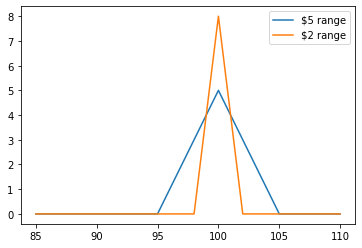

In [ ]:
#Investigating steepness
St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 5
bf_spread = ButterflySpread(r,sigma,T,K_mid,K_diff,prices)
payoff_1 = bf_spread.payoff_range
K_diff_2 = 2
bf_spread_2 = ButterflySpread(r,sigma,T,K_mid,K_diff_2,prices)
payoff_2 = bf_spread_2.payoff_range
for k in payoff_2.keys():
  payoff_2[k]*=4


plt.plot(*zip(*payoff_1.items()),label=f'${K_diff} range')
plt.plot(*zip(*payoff_2.items()),label=f'${K_diff_2} range')
plt.legend()
plt.show()

#You can scale up how much a bf spread you own to make the slope steeper

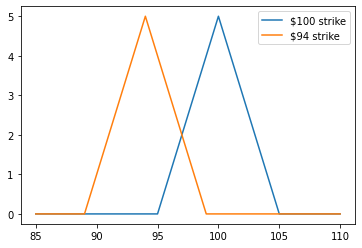

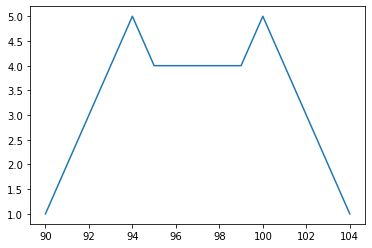

In [ ]:
#investigating portfolio of spreads
St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 5
bf_spread = ButterflySpread(r,sigma,T,K_mid,K_diff,prices)
payoff_1 = bf_spread.payoff_range

K_mid_2=94
bf_spread_2 = ButterflySpread(r,sigma,T,K_mid_2,K_diff,prices)
payoff_2 = bf_spread_2.payoff_range
#for k in payoff_2.keys():
#  payoff_2[k]*=4


plt.plot(*zip(*payoff_1.items()),label=f'${K_mid} strike')
plt.plot(*zip(*payoff_2.items()),label=f'${K_mid_2} strike')
plt.legend()
plt.show()

from collections import Counter
z = dict(Counter(payoff_1)+Counter(payoff_2))
plt.plot(*zip(*z.items()),label=f'combined')

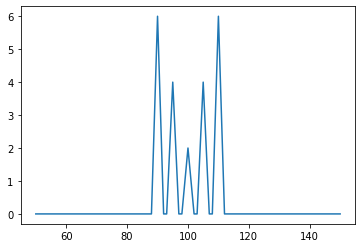

In [ ]:
#investigating portfolio of spreads
St = 100
#prices = np.arange(85,110+1)
prices = np.arange(50,150+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 2
bf_spread = ButterflySpread(r,sigma,T,K_mid,K_diff,prices)
payoff_1 = bf_spread.payoff_range

K_mid_2=95
bf_spread_2 = ButterflySpread(r,sigma,T,K_mid_2,K_diff,prices)
payoff_2 = bf_spread_2.payoff_range
for k in payoff_2.keys():
  payoff_2[k]*=2

K_mid_3=105
bf_spread_3 = ButterflySpread(r,sigma,T,K_mid_3,K_diff,prices)
payoff_3 = bf_spread_3.payoff_range
for k in payoff_3.keys():
  payoff_3[k]*=2

K_mid_4=110
bf_spread_4 = ButterflySpread(r,sigma,T,K_mid_4,K_diff,prices)
payoff_4=bf_spread_4.payoff_range
for k in payoff_4.keys():
  payoff_4[k]*=3

K_mid_5=90
bf_spread_5 = ButterflySpread(r,sigma,T,K_mid_5,K_diff,prices)
payoff_5=bf_spread_5.payoff_range
for k in payoff_5.keys():
  payoff_5[k]*=3

from collections import Counter
comb_dict={}
for k in list(payoff_1.keys()):
  comb_dict[k]=payoff_1[k]+payoff_2[k]+payoff_3[k]+payoff_4[k]+payoff_5[k]
plt.plot(*zip(*comb_dict.items()),label=f'combined')

plt.show()

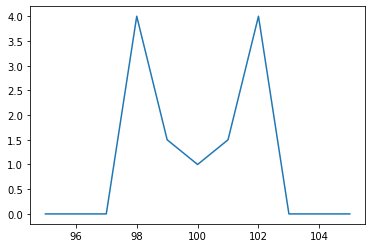

In [ ]:
#investigating portfolio of spreads
St = 100
prices = np.arange(95,105+1)
#prices = np.arange(50,150+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
K_diff = 1
bf_spread = ButterflySpread(r,sigma,T,K_mid,K_diff,prices)
payoff_1 = bf_spread.payoff_range

K_mid_2=99
bf_spread_2 = ButterflySpread(r,sigma,T,K_mid_2,K_diff,prices)
payoff_2 = bf_spread_2.payoff_range
for k in payoff_2.keys():
  payoff_2[k]*=1.5

K_mid_3=101
bf_spread_3 = ButterflySpread(r,sigma,T,K_mid_3,K_diff,prices)
payoff_3 = bf_spread_3.payoff_range
for k in payoff_3.keys():
  payoff_3[k]*=1.5

K_mid_4=102
bf_spread_4 = ButterflySpread(r,sigma,T,K_mid_4,K_diff,prices)
payoff_4=bf_spread_4.payoff_range
for k in payoff_4.keys():
  payoff_4[k]*=4

K_mid_5=98
bf_spread_5 = ButterflySpread(r,sigma,T,K_mid_5,K_diff,prices)
payoff_5=bf_spread_5.payoff_range
for k in payoff_5.keys():
  payoff_5[k]*=4

from collections import Counter
comb_dict={}
for k in list(payoff_1.keys()):
  comb_dict[k]=payoff_1[k]+payoff_2[k]+payoff_3[k]+payoff_4[k]+payoff_5[k]
plt.plot(*zip(*comb_dict.items()),label=f'combined')

plt.show()

In [ ]:
f(x) / payoff is the factor you have to scale the traingles up by

In [ ]:
from scipy.stats import gmean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

def b_motion_np(n, r, m, sig, S0, K, T, seeded=False ):
      dt= T/m #partition the total time interval into equally spaced intervals of length dt
      vol = sig*np.sqrt(dt)
      if seeded == True:
        seed= 1234
        rg = np.random.RandomState(seed) #check scale
        z_pos = rg.standard_normal(size = (int(m), int(n/2)))
      else:
        z_pos = np.random.standard_normal(size = (int(m), int(n/2)))
      z_neg = np.negative(z_pos)
      incs = np.concatenate((z_pos, z_neg),axis=1)
      incs_cumsum =  np.concatenate((np.zeros((1,n)),incs),axis=0).cumsum(axis=0)

      incs_cumsum *= vol
      tline = np.linspace(0,T,m+1)
      t_mat =  np.repeat(tline.reshape((m+1,1)), n, axis=1)
      drift_cumsum = (r - 0.5*sig**2) * t_mat
      St = S0 * np.exp(incs_cumsum + drift_cumsum)
      return St, t_mat

S0 = 100
K = 100
sig = 0.3
r = 0.03
T = 1        #total time in years
m = 1_000      #number of subvisions of total time (T) - also in years
n = 2        #number of paths
seeded = True

St,t_mat= b_motion_np(n, r, m, sig, S0, K, T, seeded=seeded)
df=pd.DataFrame(St[:,:1]).rename(columns={0:'S_t'})
df['log_ret']=np.log(df['S_t']/df['S_t'].shift(1))
df['ret']=df['S_t']/df['S_t'].shift(1) - 1
df['gross_ret']=df['S_t']/df['S_t'].shift(1)

print(df['log_ret'].sum())
print(np.log(df['S_t'].values[-1]/df['S_t'].values[0])  )
print(np.exp(df['log_ret'].sum())-1)
print('-----------------')
print(df['log_ret'].mean())
print(df['ret'].mean())
print( (df['ret'].mean()-df['log_ret'].mean())*2 )
print( sig**2/m )
print('--------------------')
print(df['log_ret'].mean())
print( df['gross_ret'].product()**(1/m)-1 )
print( np.exp(df['log_ret'].mean()) -1 )
approx=df['log_ret'].mean()
true_val=np.exp(df['log_ret'].mean()) -1
print((approx/true_val-1)*100)

#display(df)





0.13432827390866242
0.1343282739086597
0.14376822728958438
-----------------
0.00013432827390866243
0.00017694942847247376
8.524230912762266e-05
8.999999999999999e-05
--------------------
0.00013432827390866243
0.00013433729635514702
0.00013433729635514702
-0.006716263263728539


In [ ]:

def b_motion_np(n, r, m, sig, S0, K, T, seeded=False ):
      dt= T/m #partition the total time interval into equally spaced intervals of length dt
      vol = sig*np.sqrt(dt)
      if seeded == True:
        seed= 1234
        rg = np.random.RandomState(seed) #check scale
        z_pos = rg.standard_normal(size = (int(m), int(n/2)))
      else:
        z_pos = np.random.standard_normal(size = (int(m), int(n/2)))
      z_neg = np.negative(z_pos)
      incs = np.concatenate((z_pos, z_neg),axis=1)
      incs_cumsum =  np.concatenate((np.zeros((1,n)),incs),axis=0).cumsum(axis=0)

      incs_cumsum *= vol
      tline = np.linspace(0,T,m+1)
      t_mat =  np.repeat(tline.reshape((m+1,1)), n, axis=1)
      drift_cumsum = (r - 0.5*sig**2) * t_mat
      St = S0 * np.exp(incs_cumsum + drift_cumsum)
      return St, t_mat

S0 = 100
K = 100
sig = 0.3
r = 0.03
T = 1        #total time in years
m = 1_000      #number of subvisions of total time (T) - also in years
n = 2        #number of paths
seeded = True

St,t_mat= b_motion_np(n, r, m, sig, S0, K, T, seeded=seeded)
df=pd.DataFrame(St[:,:1]).rename(columns={0:'S_t'})
#df['log_ret']=np.log(df['S_t']/df['S_t'].shift(1))
df['ret']=df['S_t']/df['S_t'].shift(1) - 1
print(df['ret'].var())
print(sig**2/m)
#print(  ((sig**2/m)-df['ret'].var())/ (sig**2/m)  * 100    )

total_per_var=df['ret'].var()
cutoff=0.1
pt_1=df['ret'][:int(m*cutoff)].var()
pt_2=df['ret'][int(m*cutoff):].var()
print(pt_1,pt_2)

#loop through diff cutoffs and check diff between pt_1 and pt_2 var

8.531776165615854e-05
8.999999999999999e-05
9.028952962056148e-05 8.486424484738794e-05


In [ ]:
! pip install latex

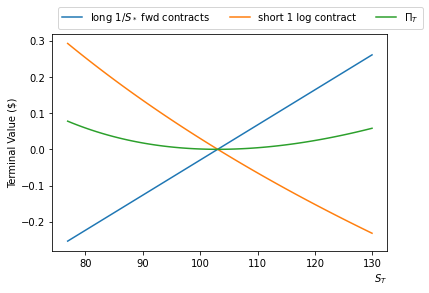

In [ ]:
S0 = 100
K = 100
sig = 0.3
r = 0.03
T = 1        #total time in years
m = 1_000      #number of subvisions of total time (T) - also in years
n = 2        #number of paths

S_ref=S0*np.exp(r*T)
ST=np.arange(S0/1.3,S0*1.3,0.5)
fwd_contracts=(ST-S_ref)/S_ref
log_contract=np.log(ST/S_ref)

plt.plot(ST,fwd_contracts,label=f'long $1/S_*$ fwd contracts')
plt.plot(ST,-log_contract,label=f'short 1 log contract')
plt.plot(ST,2/T*(fwd_contracts-log_contract),label=f'$\Pi_T$')

plt.ylabel('Terminal Value ($)')
plt.xlabel('$S_T$',loc='right')
plt.legend(ncol=3,bbox_to_anchor=(0.002, 1),loc='lower left')
plt.show()

In [ ]:
#trying to speed up with this version

#use bs_delta and gamma to be global, that way we only need to pass in d1 to bs_prices and delta_gamma_hedge
#use id x_pos to slice bs_dleta and gamma

class BS_sim_DeltaGamma_NEW:

  #Torch Price Simulation
  def b_motion_np(self, n, r, m, sig, S0, K, T, seeded=False ):
      dt= T/m #partition the total time interval into equally spaced intervals of length dt
      vol = sig*np.sqrt(dt)
      if seeded == True:
        seed= 1234
        rg = np.random.RandomState(seed) #check scale
        z_pos = rg.standard_normal(size = (int(m), int(n/2)))
      else:
        z_pos = np.random.standard_normal(size = (int(m), int(n/2)))
      z_neg = np.negative(z_pos)
      incs = np.concatenate((z_pos, z_neg),axis=1)
      incs_cumsum =  np.concatenate((np.zeros((1,n)),incs),axis=0).cumsum(axis=0)

      incs_cumsum *= vol
      tline = np.linspace(0,T,m+1)
      t_mat =  np.repeat(tline.reshape((m+1,1)), n, axis=1)
      drift_cumsum = (r - 0.5*sig**2) * t_mat
      St = S0 * np.exp(incs_cumsum + drift_cumsum)
      return St, t_mat

  #discount function
  def disc_function(self, FV, r, T):
    PV = FV * np.exp(-r*T)
    return PV

  def bs_d1_d2(self, St, r, t, K, call, sig):
    d1 = np.log(St / K)
    d1 += ( sig * sig / 2 + r ) * t
    with np.errstate(divide='ignore'):
        d1 /= sig * t**0.5
    d2 = d1 - sig * t**0.5
    return d1,d2

  def cdf_approx(self,dn,call):
    if call:
      Ndn = (0.50 * (1.0 + erf(dn / math.sqrt(2.0))))
    else:
      Ndn = (0.50 * (1.0 + erf(-dn / math.sqrt(2.0))))
    return Ndn

  def bs_delta(self,d1,d2,call):
    Nd1 = self.cdf_approx(dn=d1,call=call)
    Nd2 = self.cdf_approx(dn=d2,call=call)
    return Nd1,Nd2

  def bs_gamma(self,d1,St,sig,t):
    gamma = norm.pdf(d1)
    with np.errstate(divide='ignore'):
        gamma /= (St*sig*np.sqrt(t))
    return gamma

  def delta_gamma_hedge(self, St, sig, t, hedges_per_year,m,T, d1,call):
    hedge_intervals = T - np.arange(0,T+hedges_per_year/m, hedges_per_year/m)
    hedge_intervals = hedge_intervals[hedge_intervals>=0]
    #hedge_intervals = np.union1d(hedge_intervals, np.array([0]) ) #FORCE REBALANCE AT MATURITY
    #hedge_intervals[::-1].sort() #FORCE REBALANCE AT MATURITY
    idx_pos = np.where( np.round((T-t)[:,0],4) == np.round(hedge_intervals[:,None],4) )[1]

    deltas = self.cdf_approx(dn=d1,call=call)

    #
    #self.bs_gamma(St=St[idx_pos,:], K=K, r=r, sig=sig, t=hedge_intervals.reshape(-1,1), call=call)
    #
    gammas = self.bs_gamma(d1=d1,St=St,sig=sig,t=T-t)
    #gammas = self.bs_gamma(d1=d1,St=St,sig=sig,t=hedge_intervals.reshape(-1,1) )
    delta_tl = np.empty( (m+1,n) )
    delta_tl[:] = np.nan
    delta_tl[idx_pos,:] = deltas[idx_pos,:]
    delta_tl = delta_tl.T
    mask = np.isnan(delta_tl)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    delta_tl[mask] = delta_tl[np.nonzero(mask)[0], idx[mask]]
    #-------------------
    gamma_tl = np.empty( (m+1,n) )
    gamma_tl[:] = np.nan
    gamma_tl[idx_pos,:] = gammas[idx_pos,:]
    gamma_tl = gamma_tl.T
    mask = np.isnan(gamma_tl)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    gamma_tl[mask] = gamma_tl[np.nonzero(mask)[0], idx[mask]]
    #print(gamma_tl.T)
    return delta_tl.T , gamma_tl.T
    #return deltas, gammas

  def bs_price(self, St, r, t, K, call, Nd1,Nd2, T):
    pvk = self.disc_function(K,r, T-t)
    if call:
      price = St * Nd1 - pvk * Nd2
    else:
      price = pvk * Nd2 - St * Nd1
    return price

  def __init__(self, S0, r, sigma, T, n, m, K, K_B, T_B, hedges_per_year,seeded=False, call=True, call_B=True):
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T  = T
    self.n = n
    self.K = K
    self.m = m
    self.seeded=seeded
    self.call = call
    self.hedges_per_year = hedges_per_year

    self.K_B = K_B
    self.T_B = T_B
    self.call_B = call_B

    self.sim_prices,self.t_maturity = self.b_motion_np(n=n, r=r, m=m, sig=sigma, S0=S0, K=K, T=T, seeded=seeded)

    self.d1_a, self.d2_a = self.bs_d1_d2(St=self.sim_prices, r=r, t=T-self.t_maturity, K=K, call=call, sig=sig)
    self.d1_b, self.d2_b = self.bs_d1_d2(St=self.sim_prices, r=r, t=T-self.t_maturity, K=K_B, call=call_B, sig=sig)

    self.deltas_A, self.gammas_A = self.delta_gamma_hedge(St=self.sim_prices, sig=sig, t=self.t_maturity, hedges_per_year=hedges_per_year,m=m,T=T, d1=self.d1_a,call=call)
    self.deltas_B, self.gammas_B = self.delta_gamma_hedge(St=self.sim_prices, sig=sig, t=self.t_maturity, hedges_per_year=hedges_per_year,m=m,T=T_B, d1=self.d1_b,call=call_B)
    #print(self.gammas_A)
    #print(self.gammas_B)
    self.Nd1_A, self.Nd2_A = self.bs_delta(d1=self.d1_a,d2=self.d2_a,call=call)
    self.Nd1_B, self.Nd2_B = self.bs_delta(d1=self.d1_b,d2=self.d2_b,call=call_B)
    self.bs_prices = self.bs_price(St=self.sim_prices, r=r, t=self.t_maturity, K=K, call=call, Nd1=self.Nd1_A,Nd2=self.Nd2_A, T=T)
    self.bs_prices_B = self.bs_price(St=self.sim_prices, r=r, t=self.t_maturity, K=K_B, call=call_B, Nd1=self.Nd1_B,Nd2=self.Nd2_B, T=T_B)

    windsor_cutoff = 0.1
        #delta-gamma neutral strategy
    # A - the option the strategy owns (hedging is done for every 1 option A owned)
    # B - the option used to gamma hedge
    #1) find the number of options needed to be sold for every 1 option A owned to be gamma neutral
    with np.errstate(divide='ignore'):
        n_B = -self.gammas_A/self.gammas_B
        #display( pd.DataFrame(n_B[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )
        #n_B[self.gammas_A <= 0.0000001] = 0
        n_B = winsorize(n_B, limits=(windsor_cutoff, windsor_cutoff), axis=1)
        #display( pd.DataFrame(n_B[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )

    #2) find the number of shares to sell to be delta neutral
        n_shares = -self.deltas_A - (self.deltas_B * n_B)
        #display( pd.DataFrame(n_shares[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )
        n_shares = winsorize(n_shares, limits=(windsor_cutoff, windsor_cutoff), axis=1)
        #display( pd.DataFrame(n_shares[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )

    #3) delta-gamma neutral portfolio is the value of the option positions and the position in the shares
    self.total_port =  n_shares*self.sim_prices + self.bs_prices + n_B*self.bs_prices_B

    self.n_shares = n_shares
    self.n_B = n_B
    self.delta_port =  n_shares*1 + self.deltas_A + n_B*self.deltas_B
    self.gamma_port =  n_shares*0 + self.gammas_A + n_B*self.gammas_B

    #print('n_B')
    #display( pd.DataFrame(n_B[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )
    #print('n_shares')
    #display( pd.DataFrame(n_shares[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )
    #print(winsorize(n_B, limits=[0.01, 0.01], axis=1))
    #print('------------------------------')

    #display( pd.DataFrame(self.total_port[-1,:]).describe(percentiles=[0.01, .25, .5, .75, 0.99]) )
    #n_B[self.gammas_B <= 0.00000001] = ____


S0 = 100
K = 100
sig = 0.3
r = 0.03
T = 1        #total time in years
m = 252      #number of subvisions of total time (T) - also in years
n = 100_000 #number of paths
hedges_per_year = 7 #new hedge every 'x' days
call = True
seeded = True

K_B = 120  #the strike price of the option used in gamma hedging
T_B = 1    #the time to expiration of the option used to delta hedge
call_B = 1 #whetehr the hedging option is a call or put

####################################################################
start = timeit.default_timer()
y = BS_sim_DeltaGamma_NEW( S0=S0, r=r, sigma=sig,
                 T=T, n=n, m=m, K=K, hedges_per_year=hedges_per_year,
                 seeded=seeded,call=call,K_B=K_B,T_B=T_B, call_B=call_B ).total_port
print(y)
stop = timeit.default_timer()
print(f'runtime: {stop-start:.4f} Seconds')

In [ ]:
class BSOPM_Class:
  """
    Perform tasks related to the Black-Scholes Option Pricing Model including:
      1) computing point-in-time option prices and payoffs
      2) replicating options with dynamically traded replicating portfolios under a geometric Brownian motion
  """
  def b_motion_np(self, n, r, m, sig, S0, K, T, seeded=False ):
      """
      simulation stock prices according to a geometric. Steps are as follows:
        1) partition the total time interval into equally spaced intervals of length dt
        2) generate wiener processes over the m x n matrix (where n=numb of paths, m=numb of subdivisions in each path)
        3) use anithetic to conserve the amount of numbers
      """
      dt= T/m
      vol = sig*np.sqrt(dt)
      if seeded == True:
        seed= 1234
        rg = np.random.RandomState(seed)
        z_pos = rg.standard_normal(size = (int(m), int(n/2)))
      else:
        z_pos = np.random.standard_normal(size = (int(m), int(n/2)))
      z_neg = np.negative(z_pos)
      incs = np.concatenate((z_pos, z_neg),axis=1)
      incs_cumsum =  np.concatenate((np.zeros((1,n)),incs),axis=0).cumsum(axis=0)
      incs_cumsum *= vol
      tline = np.linspace(0,T,m+1)
      t_mat =  np.repeat(tline.reshape((m+1,1)), n, axis=1)
      drift_cumsum = (r - 0.5*sig**2) * t_mat
      St = S0 * np.exp(incs_cumsum + drift_cumsum)
      return St, t_mat

  def disc_function(self, FV, r, T): #discount function
    PV = FV * np.exp(-r*T)
    return PV

  def bs_delta(self, St, r, t, K, call, sig): #Black-Scholes Delta
    d1 = np.log(St / K)
    d1 += ( sig * sig / 2 + r ) * t
    d1 /= sig * t**0.5
    d2 = d1 - sig * t**0.5
    if call:
      Nd1 = (0.50 * (1.0 + erf(d1 / math.sqrt(2.0))))
      Nd2 = (0.50 * (1.0 + erf(d2 / math.sqrt(2.0))))
      return Nd1,Nd2
    else:
      Nd1 = (0.50 * (1.0 + erf(-d1 / math.sqrt(2.0))))
      Nd2 = (0.50 * (1.0 + erf(-d2 / math.sqrt(2.0))))
      return Nd1,Nd2

  def bs_gamma(self, St, r, t, K, call, sig): #Black-Scholes Gamma
    d1 = np.log(St / K)
    d1 += ( sig * sig / 2 + r ) * t
    d1 /= sig * t**0.5
    gamma = norm.pdf(d1)
    gamma /= (St*sig*np.sqrt(t))
    return gamma

  def bs_price(self, St, r, t, K, call, sig, T):
    Nd1,Nd2 = self.bs_delta(St=St, r=r, t=T-t, K=K, call=call, sig=sig)
    pvk = self.disc_function(K,r, T-t)
    if call:
      price = St * Nd1 - pvk * Nd2
    else:
      price = pvk * Nd2 - St * Nd1
    return price

  def opt_payoff(self, ST, K, call=True):
    if call == True:
      payoff = np.maximum( ST-K, 0 )
    else:
      payoff = np.maximum( K-ST, 0 )
    return payoff

  def __init__(self, S0, r, sigma, T, n, m, K,seeded=False, call=True):
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T  = T
    self.n = n
    self.K = K
    self.m = m
    self.seeded=seeded
    self.call = call
    self.price = self.bs_price(self.S0, self.r,0,self.K,self.call, self.sigma, self.T)
    self.payoff = self.opt_payoff(self.S0,self.K,self.call)
